# **Ajuste de la temperatura del CMB a un cuerpo negro (datos de COBE)**
**Técnicas Computacionales Básicas**

**Pablo Contreras**


The Cosmic Background Explorer (COBE), developed by NASA, was a satellite  to measure the diffuse infrared and microwave radiation from the early universe to the limits set by our astrophysical environment. It was launched November 18, 1989 and carried three instruments, a Diffuse Infrared Background Experiment (DIRBE) to search for the cosmic infrared background radiation, a Differential Microwave Radiometer (DMR) to map the cosmic radiation sensitively, and a Far Infrared Absolute Spectrophotometer (FIRAS) to compare the spectrum of the cosmic microwave background radiation with a precise blackbody. Each COBE instrument yielded a major cosmological discovery:

* DIRBE - Infrared absolute sky brightness maps in the wavelength range 1.25 to 
240 microns were obtained to carry out a search for the cosmic infrared background (CIB). The CIB represents a "core sample" of the Universe; it contains the cumulative emissions of stars and galaxies dating back to the epoch when these objects first began to form. The COBE CIB measurements constrain models of the cosmological history of star formation and the buildup over time of dust and elements heavier than hydrogen, including those of which living organisms are composed. Dust has played an important role in star formation throughout much of cosmic history.
* DMR - The CMB was found to have intrinsic "anisotropy" for the first time, at a level of a part in 100,000. These tiny variations in the intensity of the CMB over the sky show how matter and energy was distributed when the Universe was still very young. Later, through a process still poorly understood, the early structures seen by DMR developed into galaxies, galaxy clusters, and the large scale structure that we see in the Universe today.
* FIRAS - The cosmic microwave background (CMB) spectrum is that of a nearly perfect blackbody with a temperature of 2.725 +/- 0.002 K. This observation matches the predictions of the hot Big Bang theory extraordinarily well, and indicates that nearly all of the radiant energy of the Universe was released within the first year after the Big Bang.

In this work, I will adjust and compare the CMB spectrum at each position at the sky with that of a blackbody and get the temperature for each position. From the fitting results, I get a CMB temperature map and compare it with the temperature map data product from the COBE FIRAS product page. An overall agreement is evident.

Let's first start installing and importing the python packages to be used in the script as well as definining functions to calculate a blackbody spectrum given a temperature and to calculate the reduced chi square value to check the fit.

In [1]:
!pip install healpy

     |████████████████████████████████| 15.8MB 282kB/s 


In [7]:
from astropy.io import fits
from astropy.modeling import models
from scipy.optimize import curve_fit
from astropy import units as u
import pylab as plt
import numpy as np
import healpy as hp
from astropy.visualization import quantity_support

In [3]:
def blackbody_wn(wn, T):
    """ Blackbody as a function of wavenumber (cm^-1) and temperature (K).
    returns units of MJy/Steradian (but in a dimmensionles array)

    Input:
     wn     Spectral axis in wavenumber (cm^-1)
     T      Temperature for blackbody espectrum (K)
    """
    from astropy import units as u # Astropy models require dimensions and units
    bb1 = models.BlackBody(T*u.K)
    flux = (bb1(wn/u.cm)).to(u.MJy/u.sr)
    return flux*u.sr/u.MJy # To return a dimensionless array

def calc_reduced_chi_square(fit, x, y, yerr, N, n_free):
    '''
    fit (array) values for the fit
    x,y,yerr (arrays) data
    N total number of points
    n_free number of parameters we are fitting
    '''
    return 1.0/(N-n_free)*sum(((fit - y)/yerr)**2)

# CMB MONOPOLE Blackbody radiation fit

The COBE FIRAS data products page provides a CMB spectrum from Fixsen et al. (1996) which modeled the full FIRAS low-frequency calibrated sky spectra as a superposition of a CMB monopole, a CMB dipole and selected Galactic emission components. Table 4 of their paper gives the residuals of the derived CMB monopole spectrum from a perfect blackbody. Subsequent analyses by Mather et al. (1999) and Fixsen et al. (2002) improved the FIRAS calibration accuracy and provided a best-estimate for the absolute CMB temperature of 2725 +/- 1 mK.

The CMB monopole spectrum in the file "firas_monopole_spec_v1.txt" is the sum of a 2.725 K blackbody spectrum and the residual intensity noted above. The complete contents of Table 4 are also provided, in the form of the original residuals, 1-sigma uncertainties, and the modeled Galaxy spectrum.

First I performed the fit to this spectrum, as shown bellow the fit is perfect and the temperature is the same as in the CMB monopole spectrum. Also, the reduced chi square, close to 1 shows a good fit. The routine used to perform the fit is scipy.optimize.curve_fit, which uses non-linear least squares to fit a function given a first guess for the function parameters. It returns two arrays, one with the best parameters for the function, and the other corresponds to the covariance matrix from the fit. Of special interest, the diagonal of this matrix gives the variance for each paramater. For this case, the routine just returns the best temperature of the fit and its correspondent variance.

In [4]:
monopole = np.loadtxt('firas_monopole_spec_v1.txt') # Read the spectrum file

In [5]:
# Obtain the best fit with scipy.optimize routines with blackbody function defined above
popt, pcov = curve_fit(blackbody_wn, monopole[:,0], monopole[:,1], p0=1., sigma=monopole[:,3]*0.001) # Adjust the same units in the uncertainty column from the CMB spectrum file

# Calculate the reduced chi square statistic
reduced_chi_squared = calc_reduced_chi_square(blackbody_wn(monopole[:,0], popt), monopole[:,0], monopole[:,1], monopole[:,3]*0.001, len(monopole[:,0]), 1)

print('CMB Monopole temperature: 2.725 +/- 0.001 K')
print('Blackbody temperature from fit: {:.3f} +/- {:.1} K'.format(popt[0],np.sqrt(pcov[0][0])))
print('Reduced Chi Squared: {:.3f}'.format(reduced_chi_squared))

CMB Monopole temperature: 2.725 +/- 0.001 K
Blackbody temperature from fit: 2.725 +/- 8e-06 K
Reduced Chi Squared: 1.074


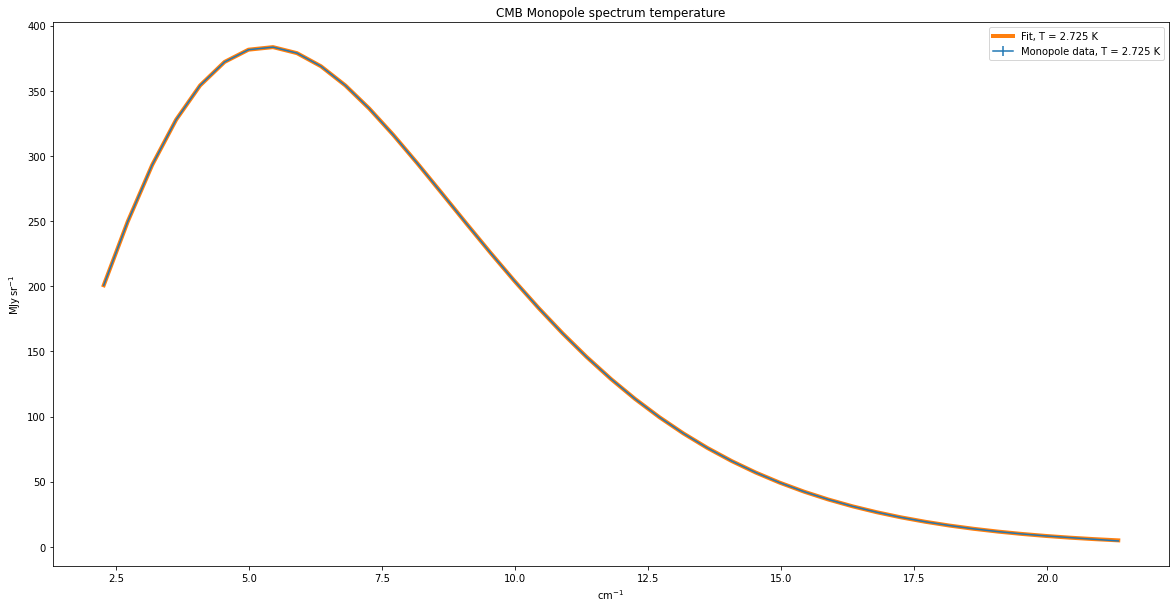

In [8]:
with quantity_support():
    plt.figure(figsize=(20, 10))
    plt.errorbar(monopole[:,0]/u.cm, monopole[:,1]*u.MJy/u.sr,monopole[:,3]*0.001*u.MJy/u.sr, label = 'Monopole data, T = 2.725 K')
    plt.plot(monopole[:,0]/u.cm, blackbody_wn(monopole[:,0], popt[0])*u.MJy/u.sr, linewidth = 4, label='Fit, T = {:.3f} K'.format(popt[0]))
    plt.legend(loc=1)
    plt.title('CMB Monopole spectrum temperature')
    plt.show()

# CMB All sky spectrum, blakbody fit at each pixel

Given that the fitting method is good, I can move on to something a bit more elaborate. From the COBE FIRAS product page, there are three main Spectral Sky Maps: two low-spectral resolution products (FIRAS_DESTRIPED_SKY_SPECTRA_LOWF.FITS, and FIRAS_DESTRIPED_SKY_SPECTRA_HIGH.FITS, which cover the full FIRAS frequency range at ~25 GHz resolution; and a high-spectral resolution product called FIRAS_DESTRIPED_SKY_SPECTRA_HRES.FITS, which covers the frequency range 30 - 660 GHz at 6.9 GHz resolution. These files contain a spectrum at each pixel and were created by coadding spectra obtained from various FIRAS channel and scan mode combinations. Prior to coaddition, the observations made in different modes were calibrated to remove the instrument signature. "Destriping" is a secondary calibration step applied to compensate for unidentified instrumental offsets. The existence of such offsets is suggested by stripes that appear in an untreated sky map at a particular frequency.

I used the high-spectral resolution full sky map in the file "FIRAS_DESTRIPED_SKY_SPECTRA_HRES.FITS". The file contains a high resolution spectrum at each pixel in the sky. I performed a fit for each spectrum to a perfect blackbody and obtained the temperature for each position at the sky. The method used is the same as in the CMB monopole spectrum. Overall, the obtained temperatures are similar to the characteristic temperature of the CMB and the plots show a good agreement with the blackbody spectrum. This time around I was not able to obtain the reduced statistics as the file does not include uncertainty for each spectrum.

In [9]:
cobe_spectrum = fits.open('FIRAS_DESTRIPED_SKY_SPECTRA_HRES.FITS')
data = cobe_spectrum[1].data
cobe_spectrum.close()

In [10]:
temp = []
cov = []
wn_axis = np.linspace(.85,22.,182)
for i in range(0,len(data)):
  spec_try = data[i][5]
  popt_1, pcov_1 = curve_fit(blackbody_wn,wn_axis, spec_try, p0=1.)
  temp.append(popt_1[0])
  cov.append(pcov_1[0][0])

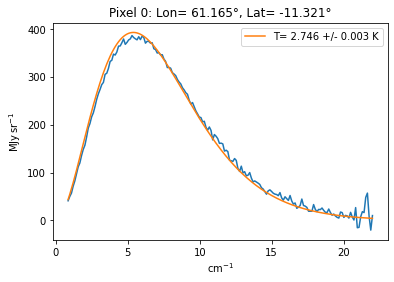

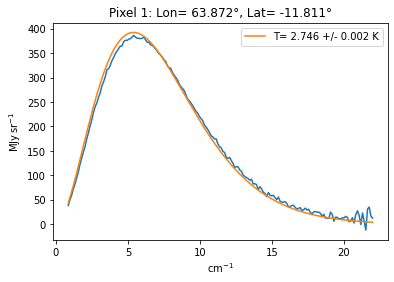

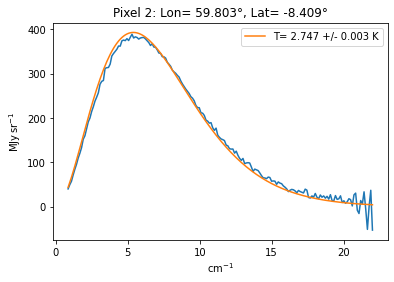

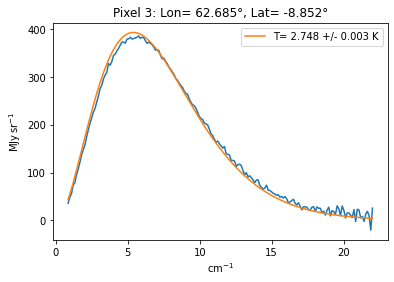

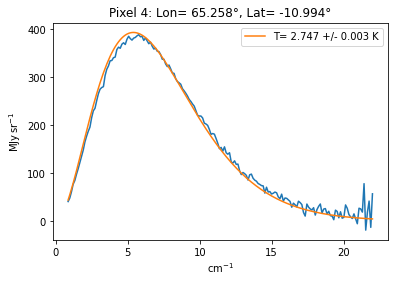

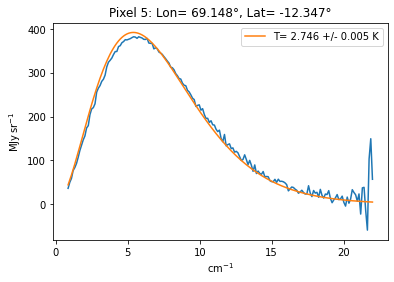

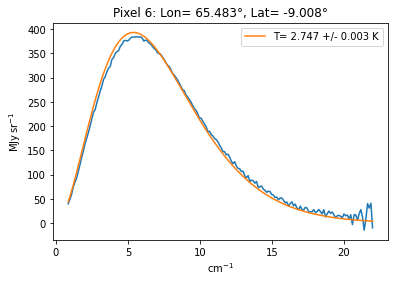

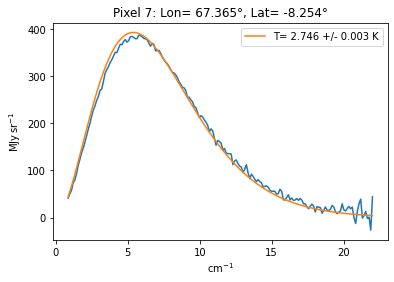

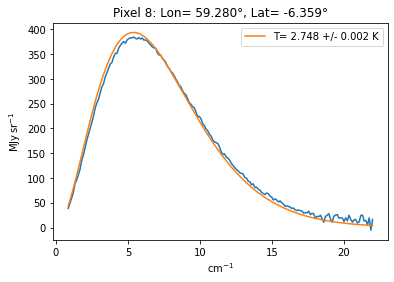

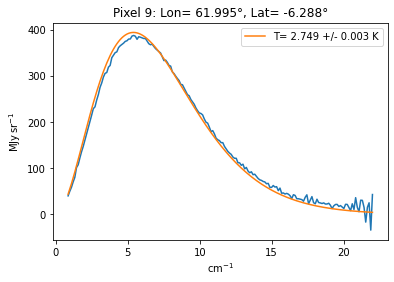

In [11]:
# Plot the fit for the first ten sky positions (pixels)

for i in range(0,10):
  with quantity_support():
    plt.figure()
    plt.plot(wn_axis/u.cm, data[i][5]*u.MJy/u.sr)
    plt.plot(wn_axis/u.cm, blackbody_wn(wn_axis, temp[i])*u.MJy/u.sr, label='T= {:.3f} +/- {:.1} K'.format(temp[i],np.sqrt(cov[i])))
    plt.title('Pixel {}: Lon= {:.3f}°, Lat= {:.3f}°'.format(data[i][0], data[i][1], data[i][2]))
    plt.legend(loc=0)
    plt.show()

# CMB Temperature Maps (Comparison)

Once I obtained the temperature for each pixel, I can plot a CMB temperature map in the sky. To plot the map I used the Healpix software through healpy routine. First it is necessary to initiate the resolution of the healpix map and then assign the value for each healpix pixel.

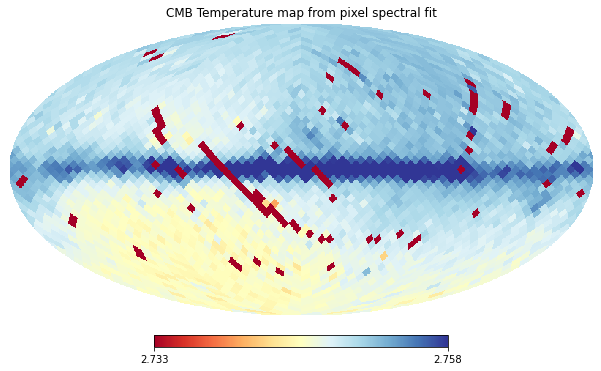

In [16]:
lon = np.zeros(len(data))
lat = np.zeros(len(data))
for i in range(0,len(data)):
  lon[i]+=data[i][1]
  lat[i]+=data[i][2]

# Set the number of sources and the coordinates for the input
nside = 16
npix = hp.nside2npix(nside)

# Go from HEALPix coordinates to indices
indices = hp.ang2pix(nside, lon, lat, lonlat=True)

# Create a empty healpix map
hpxmap = np.zeros(npix, dtype=np.float)

# With the healpix indices assign the temperature data to each healpix pixel
for i in range(len(data)):
    if hpxmap[indices[i]]==0:
      hpxmap[indices[i]] += temp[i]
    else:
      hpxmap[indices[i]] = (hpxmap[indices[i]] + temp[i])/2

# Display the map
hp.mollview(hpxmap, cmap='RdYlBu', min=2.733, max = 2.758, title= 'CMB Temperature map from pixel spectral fit')
# min value to avoid pixels without data
# max value to avoid pixels with higher temperatures due to milky way band

From the COBE FIRAS product page I retrieved a file called "FIRAS_TEMPERATURE_MAP_LOWF.FITS" which contains maps of the CMB temperature and its uncertainty, parameters of a dipole fit to the CMB temperature map (amplitude, direction, and associated uncertainties), and the average CMB temperature measured by FIRAS (2.728 +/- 0.004 K). Following the same proccedure as the map I obtained from the fit, I plotted the map from this file.

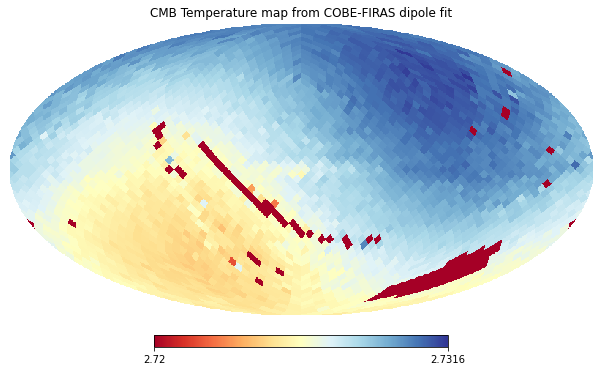

In [17]:
hdulist = fits.open('FIRAS_TEMPERATURE_MAP_LOWF.FITS')
cmb_map = hdulist[1].data
hdulist.close()

lon = np.zeros(len(cmb_map))
lat = np.zeros(len(cmb_map))
temp_1 = np.zeros(len(cmb_map))
for i in range(0,len(cmb_map)):
  lon[i]+=cmb_map[i][1]
  lat[i]+=cmb_map[i][2]
  temp_1[i]+=cmb_map[i][4]

# Go from HEALPix coordinates to indices
indices = hp.ang2pix(nside, lon, lat, lonlat=True)

# With the healpix indices assign the temperature data to each healpix pixel
hpxmap2 = np.zeros(npix, dtype=np.float)
for i in range(len(data)):
    if hpxmap2[indices[i]]==0:
      hpxmap2[indices[i]] += temp_1[i]
    else:
      hpxmap2[indices[i]] = (hpxmap2[indices[i]] + temp_1[i])/2

# Display the map
hp.mollview(hpxmap2, cmap='RdYlBu', min=2.72, title='CMB Temperature map from COBE-FIRAS dipole fit')
# min value to avoid pixels without data

Comparing the full sky temperature maps it is evident that both show a similar structure with small variations in temperature from pixel to pixel and a large dipole structure due to the doppler shift from the movement with respect to the Hubble space. There are pixels on both maps that do not contain data and, in the map obtained from the fit, pixels with higher temperatures along the central plane (Milky Way) that are assigned the maximum color.

Comparing the temperature values, the temperatures from the fit are higher in about 0.01 to 0.02 K for every position in the sky. Maybe, this is because the spectrum at every position still has a contribution from Milky Way's radiation, as the milky way band is visible in the map.

**References**

* The information about COBE satellite and the data products used here was retrieved from: https://lambda.gsfc.nasa.gov/product/cobe/
* Astrophysical Journal, 473, 576 (1996). THE COSMIC MICROWAVE BACKGROUND SPECTRUM FROM THE FULL COBE FIRAS DATA SETS. D.J. Fixsen, E.S. Cheng, J.M. Gales, J.C. Mather, R.A. Shafer, and E.L. Wright

* Astrophysical Journal, 512, 511 (1999). CALIBRATOR DESIGN FOR THE COBE FAR INFRARED ABSOLUTE SPECTROPHOTOMETER (FIRAS). J.C. Mather, D.J. Fixsen, R.A. Shafer, C. Mosier, and D.T. Wilkinson

* Atrophysical Journal, 581, 2 (2002). The Spectral Results of the Far-Infrared Absolute Spectrophotometer Instrument on COBE. D. J. Fixsen and J. C. Mather

* A&A 558, A33 (2013). Astropy: A community Python package for astronomy. The Astropy Collaboration

* Nat Methods 17, 261–272 (2020). SciPy 1.0: fundamental algorithms for scientific computing in Python. Virtanen, P., Gommers, R., Oliphant, T.E. et al.

* The Astrophysical Journal, 622, 2 (2005). HEALPix: A Framework for High-Resolution Discretization and Fast Analysis of Data Distributed on the Sphere. Górski, K. M.; Hivon, E.; Banday, A. J.; Wandelt, B. D.; Hansen, F. K.; Reinecke, M.; Bartelmann, M.

* Journal of Open Source Software, 4(35) (1298). healpy: equal area pixelization and spherical harmonics transforms for data on the sphere in Python. Zonca et al., (2019).